In [1]:
import pandas as pd
import numpy as np
import scipy.stats as st
import seaborn as sns
import sys
import os
import gseapy as gp
import matplotlib.pyplot as plt
import swan_vis as swan
import yaml
from snakemake.io import expand

p = os.path.dirname(os.path.dirname(os.getcwd()))
sys.path.append(p)

from proc_revisions.utils import *
from proc_revisions.plotting import *

In [2]:
od = '../../proc_revisions/'
config_file = f'{od}/config.yml'
with open(config_file) as f:
    config = yaml.safe_load(f)

In [161]:
ab = od+expand(config['lr']['talon']['fusion_fix']['ab'], species='human')[0]
filt_ab = od+expand(config['lr']['cerberus']['filt_ab'], species='human')[0]
read_annot = od+expand(config['lr']['talon']['full_annot'], species='human')[0]
t_metadata = od+expand(config['ref']['cerberus']['new_gtf_t_info'], species='human')[0]
lib_meta = od+expand(config['lr']['meta'], species='human')[0]
swan_file = od+expand(config['lr']['swan']['sg'], species='human')[0]
cerberus_h5 = od+expand(config['lr']['cerberus']['ca_triplets'], species='human', obs_col='sample')[0]
cerb_t_metadata = od+expand(config['lr']['cerberus']['gtf_t_info'], species='human')[0]
major_isos = od+expand(config['lr']['analysis']['major_isos'], species='human', obs_col='sample')[0]
pi_tpm_table = od+expand(config['lr']['mane']['pi_tpm']['triplet'], species='human', obs_col='sample')[0]

ref_t_metadata = od+expand(config['ref']['new_gtf_t_info'], species='human')[0]
ref_g_metadata = od+expand(config['ref']['new_gtf_g_info'], species='human')[0]
read_annot = od+expand(config['lr']['talon']['full_annot'], species='human')[0]

# pp_summary = '../'+expand(config['data']['p_pred']['summary'], species='human')[0]

ver = 'v40_cerberus'
min_tpm = 1
gene_subset = 'polya'
obs_col = 'sample'
go_gene_subset = 'protein_coding'
predom_iso_subset = 'protein_coding'

m_lib_meta = od+expand(config['lr']['meta'], species='mouse')[0]

In [162]:
# https://academic.oup.com/bib/article/18/2/205/2562739

In [163]:
df = pd.read_csv(filt_ab, sep='\t')
df, tids = get_tpm_table(df,
                   how='iso',
                   min_tpm=min_tpm,
                   gene_subset=gene_subset,
                    groupby='sample')

Calculating iso TPM values
Subsetting for polya genes


/Users/fairliereese/Documents/programming/mortazavi_lab/data/paper_rnawg/proc_revisions/utils.py:2110: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[tpm_col] = (df[d]*1000000)/df[total_col]
/Users/fairliereese/Documents/programming/mortazavi_lab/data/paper_rnawg/proc_revisions/utils.py:2109: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[total_col] = df[d].sum()


Enforcing minimum TPM
Total # isos detected: 236615
# isos >= 1 tpm: 213476
Applying gene type and novelty subset
Averaging over biosample
Found 51 total samples
Number of isos reported: 209819


In [ ]:
def compute_tau(df):
    """
    Compute tissue-specificity index for an abundance matrix output
    from `get_tpm_table`.
    """
    # number of samples 
    n = len(df.columns)
    print(f'Found {n} samples')
    
    # log-transform data and add 1 pseudocount to data
    df = np.log2(df+1)
    # df.replace([np.inf, -np.inf], np.nan, inplace=True)
    
    # get max of TPM for transcript across tissues
    temp = df.max(axis=1)
    temp_ind = temp.index.tolist()

    df = df.transpose()
    df_ind = df.columns.tolist()
    assert df_ind==temp_ind

    # compute x-hat (TPM / max TPM across tissues)
    x_hat = df/temp
    
    # compute (1-x-hat) 
    x_hat = 1-x_hat

    # compute sum across tissues
    x_hat = x_hat.transpose()
    x_hat['sum'] = x_hat.sum(axis=1)
    
    # compute tau for each transcript
    x_hat['tau'] = x_hat['sum']/n
    tau_df = x_hat[['tau']]
    
    return 

51


In [166]:
# data = [[1,1,1,1],
#         [0.1,0.1,10,0.1],
#         [2,2,2,2]]
# df = pd.DataFrame(data=data, columns=['s1', 's2', 's3', 's4'],
#                   index=['t1', 't2', 't3'])

In [167]:
df.head()

biosample,a673,adipose,adrenal_gland,brain,brain_ad,caco2,calu3,colon,gm12878,h1,...,ovary,panc1,pc3,pc9,pgp1,pgp1_astro,pgp1_endo,pgp1_excite_neuron,vessels,wtc11
"ENSG00000000003[1,1,1]",1.733190,0.000000,0.335189,0.000000,0.217164,2.958155,1.872915,1.691512,0.000000,3.261205,...,1.094849,1.016173,2.440375,0.884333,0.000000,0.876585,0.000000,0.000000,0.000000,1.775920
"ENSG00000000003[1,1,5]",4.829348,4.920507,3.490580,2.258819,1.987063,6.379713,5.223717,6.200521,0.000000,5.348525,...,5.095990,2.347718,4.586447,4.897687,4.689386,4.290189,3.952059,3.290895,2.020468,4.565957
"ENSG00000000003[1,1,6]",0.965777,0.877116,1.193791,0.000000,0.000000,2.662224,1.691813,2.702899,0.000000,1.066972,...,1.177957,0.000000,0.000000,1.635398,0.000000,0.000000,0.000000,0.000000,0.000000,0.872474
"ENSG00000000003[1,1,7]",5.435014,6.205410,4.888319,3.533010,2.864217,7.528258,6.878174,6.904611,0.311456,6.303109,...,5.773188,3.936934,5.413512,6.313919,5.812378,5.735094,5.946887,5.044624,3.814640,6.129888
"ENSG00000000003[1,1,8]",5.240317,5.420718,5.131857,2.065805,1.774764,7.465929,6.247279,6.777914,0.000000,5.187088,...,4.035655,2.024191,4.784868,5.431852,5.668043,4.768783,6.465946,4.777258,3.082213,5.218145


In [168]:
df.head()

biosample,a673,adipose,adrenal_gland,brain,brain_ad,caco2,calu3,colon,gm12878,h1,...,ovary,panc1,pc3,pc9,pgp1,pgp1_astro,pgp1_endo,pgp1_excite_neuron,vessels,wtc11
"ENSG00000000003[1,1,1]",1.733190,0.000000,0.335189,0.000000,0.217164,2.958155,1.872915,1.691512,0.000000,3.261205,...,1.094849,1.016173,2.440375,0.884333,0.000000,0.876585,0.000000,0.000000,0.000000,1.775920
"ENSG00000000003[1,1,5]",4.829348,4.920507,3.490580,2.258819,1.987063,6.379713,5.223717,6.200521,0.000000,5.348525,...,5.095990,2.347718,4.586447,4.897687,4.689386,4.290189,3.952059,3.290895,2.020468,4.565957
"ENSG00000000003[1,1,6]",0.965777,0.877116,1.193791,0.000000,0.000000,2.662224,1.691813,2.702899,0.000000,1.066972,...,1.177957,0.000000,0.000000,1.635398,0.000000,0.000000,0.000000,0.000000,0.000000,0.872474
"ENSG00000000003[1,1,7]",5.435014,6.205410,4.888319,3.533010,2.864217,7.528258,6.878174,6.904611,0.311456,6.303109,...,5.773188,3.936934,5.413512,6.313919,5.812378,5.735094,5.946887,5.044624,3.814640,6.129888
"ENSG00000000003[1,1,8]",5.240317,5.420718,5.131857,2.065805,1.774764,7.465929,6.247279,6.777914,0.000000,5.187088,...,4.035655,2.024191,4.784868,5.431852,5.668043,4.768783,6.465946,4.777258,3.082213,5.218145


In [169]:
# get max of TPM for transcript across tissues
temp = df.max(axis=1)
temp_ind = temp.index.tolist()

df = df.transpose()
df_ind = df.columns.tolist()
assert df_ind==temp_ind

# compute x-hat (TPM / max TPM across tissues)
x_hat = df/temp

In [170]:
x_hat.transpose()

biosample,a673,adipose,adrenal_gland,brain,brain_ad,caco2,calu3,colon,gm12878,h1,...,ovary,panc1,pc3,pc9,pgp1,pgp1_astro,pgp1_endo,pgp1_excite_neuron,vessels,wtc11
"ENSG00000000003[1,1,1]",0.531457,0.000000,0.102781,0.000000,0.066590,0.907074,0.574302,0.518677,0.000000,1.000000,...,0.335719,0.311594,0.748305,0.271168,0.000000,0.268792,0.000000,0.000000,0.000000,0.544559
"ENSG00000000003[1,1,5]",0.595226,0.606461,0.430220,0.278404,0.244909,0.786311,0.643833,0.764226,0.000000,0.659215,...,0.628090,0.289361,0.565288,0.603649,0.577975,0.528774,0.487099,0.405609,0.249026,0.562762
"ENSG00000000003[1,1,6]",0.215703,0.195901,0.266629,0.000000,0.000000,0.594599,0.377861,0.603684,0.000000,0.238305,...,0.263093,0.000000,0.000000,0.365261,0.000000,0.000000,0.000000,0.000000,0.000000,0.194864
"ENSG00000000003[1,1,7]",0.578772,0.660811,0.520555,0.376229,0.305009,0.801681,0.732453,0.735269,0.033167,0.671215,...,0.614784,0.419242,0.576482,0.672366,0.618957,0.610727,0.633281,0.537200,0.406219,0.652769
"ENSG00000000003[1,1,8]",0.701897,0.726061,0.687370,0.276698,0.237715,1.000000,0.836772,0.907846,0.000000,0.694768,...,0.540543,0.271124,0.640894,0.727552,0.759188,0.638739,0.866060,0.639875,0.412837,0.698928
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"ENSG00000285976[2,4,1]",0.147439,0.256460,0.000000,0.000000,0.000000,0.364483,0.357058,0.159431,0.321888,0.137250,...,0.000000,0.297119,0.000000,0.000000,0.000000,0.373163,0.000000,0.267355,0.000000,0.289734
"ENSG00000285976[3,5,2]",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.054142,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.115991,0.000000
"ENSG00000285976[4,6,2]",0.000000,0.000000,0.267210,0.190441,0.055520,0.000000,0.000000,0.618529,0.318840,0.150104,...,0.148132,0.513712,0.292592,0.000000,0.000000,0.000000,0.288477,0.000000,0.361763,0.135432
"ENSG00000285988[1,1,2]",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.651749,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [171]:
# 2.324621/8.587834

In [172]:
# 27.430118/275.947765

In [174]:
# compute (1-x-hat) 
x_hat = 1-x_hat

# compute sum across tissues
x_hat = x_hat.transpose()
x_hat['sum'] = x_hat.sum(axis=1)

In [175]:
x_hat

biosample,a673,adipose,adrenal_gland,brain,brain_ad,caco2,calu3,colon,gm12878,h1,...,panc1,pc3,pc9,pgp1,pgp1_astro,pgp1_endo,pgp1_excite_neuron,vessels,wtc11,sum
"ENSG00000000003[1,1,1]",0.468543,1.000000,0.897219,1.000000,0.933410,0.092926,0.425698,0.481323,1.000000,0.000000,...,0.688406,0.251695,0.728832,1.000000,0.731208,1.000000,1.000000,1.000000,0.455441,40.260874
"ENSG00000000003[1,1,5]",0.404774,0.393539,0.569780,0.721596,0.755091,0.213689,0.356167,0.235774,1.000000,0.340785,...,0.710639,0.434712,0.396351,0.422025,0.471226,0.512901,0.594391,0.750974,0.437238,30.258875
"ENSG00000000003[1,1,6]",0.784297,0.804099,0.733371,1.000000,1.000000,0.405401,0.622139,0.396316,1.000000,0.761695,...,1.000000,1.000000,0.634739,1.000000,1.000000,1.000000,1.000000,1.000000,0.805136,40.901665
"ENSG00000000003[1,1,7]",0.421228,0.339189,0.479445,0.623771,0.694991,0.198319,0.267547,0.264731,0.966833,0.328785,...,0.580758,0.423518,0.327634,0.381043,0.389273,0.366719,0.462800,0.593781,0.347231,27.876345
"ENSG00000000003[1,1,8]",0.298103,0.273939,0.312630,0.723302,0.762285,0.000000,0.163228,0.092154,1.000000,0.305232,...,0.728876,0.359106,0.272448,0.240812,0.361261,0.133940,0.360125,0.587163,0.301072,25.697614
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"ENSG00000285976[2,4,1]",0.852561,0.743540,1.000000,1.000000,1.000000,0.635517,0.642942,0.840569,0.678112,0.862750,...,0.702881,1.000000,1.000000,1.000000,0.626837,1.000000,0.732645,1.000000,0.710266,39.502349
"ENSG00000285976[3,5,2]",1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.945858,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.884009,1.000000,48.189505
"ENSG00000285976[4,6,2]",1.000000,1.000000,0.732790,0.809559,0.944480,1.000000,1.000000,0.381471,0.681160,0.849896,...,0.486288,0.707408,1.000000,1.000000,1.000000,0.711523,1.000000,0.638237,0.864568,40.950336
"ENSG00000285988[1,1,2]",1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.348251,1.000000,1.000000,1.000000,...,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,49.348251


In [176]:
# compute tau for each transcript
x_hat['tau'] = x_hat['sum']/n

In [177]:
n

51

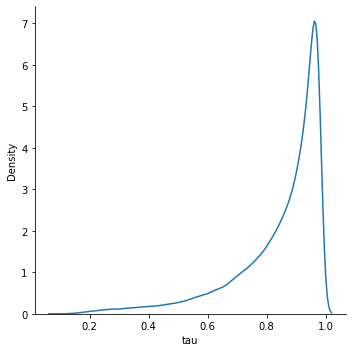

In [178]:
sns.displot(data=x_hat, x='tau', kind='kde')